In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import json
import re
import string

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses

2025-11-03 13:50:31.423872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762177831.653089      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762177831.727687      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Parameters
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS = 128
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 25

In [4]:
with open ("/kaggle/input/epirecipes/full_format_recipes.json", 'r') as f:
    recipe_data= json.load(f)

In [5]:
filtered_data = [
    "Recipe for " + x["title"] + " | " + " ".join(x["directions"])
    for x in recipe_data
    if "title" in x
    and x["title"] is not None
    and "directions" in x
    and x["directions"] is not None
]

In [6]:
n_recipes= len(filtered_data)
print(n_recipes)

20111


In [7]:
a= filtered_data[0]
print(a)

Recipe for Lentil, Apple, and Turkey Wrap  | 1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool. 2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper. 3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.


In [9]:
# Tokenize
def pad_puntuation(s):
    s = re.sub(r"([{}])".format(string.punctuation), r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s
text_data= [pad_puntuation(x.lower()) for x in filtered_data]

In [10]:
text_ds= (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

I0000 00:00:1762178068.782335      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762178068.783048      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [11]:
vectorize= layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN+1,
)

In [12]:
vectorize.adapt(text_ds)
vocab= vectorize.get_vocabulary()
print("Vocabulary size:", len(vocab))

Vocabulary size: 10000


In [13]:
for i,word in enumerate(vocab[:10]):
    print(i,word)

0 
1 [UNK]
2 .
3 ,
4 and
5 to
6 in
7 the
8 with
9 a


In [15]:
example = text_data[0]

In [16]:
example_tokenised = vectorize(example)
example_tokenised.numpy()

array([  26,   16, 1733,    3,  428,    3,    4,  221,  212,   27,   11,
          2,   64,    7,  300,    3,  924,    3,  353,    3,  576,    3,
        307,    3,    4,   24,    6,    9,   29,   80,    4,   84,    5,
          9,   69,    2,  153,   17,    5,  134,    4,   70,   10,    7,
        924,   79,   85,    3,   19,  126,   12,    3, 1135,   28,    7,
        924,    2,   34,   92,  316,  601,    5,  162,  124,    3,   18,
         39,  151,  542,    2,   35,   71,    4,  206,    7,  307,    2,
        120,    4,   40,    7,   31,    5,    9,   21,   22,   67,   60,
          2,   15,    2,  255,    6,    7,  265,    3,  428,    3,  109,
        104,    3,    4,  252,   37,    2,   63,    8,    7,   33,    2,
         36,    2,    5, 1567,    9,  212,    3,   64,   11, 2863,  105,
         28,    9,  370,  387,  207,    2,  166,  256,   14,    7, 1733,
         31,   28,    7,  613, 1908,  215,    3,  447,    9,   11,   13,
         53,  813,    2,   72,    8,  688,  160,   

In [17]:
# Training set
def prepare_ips(text):
    txt= tf.expand_dims(text, -1)
    tokenized= vectorize(txt)
    x= tokenized[:,:-1]
    y= tokenized[:,1:]
    return x, y

train_ds= text_ds.map(prepare_ips)

In [47]:
# Build LSTM (less goo)
ips= layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(ips)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
ops = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm= models.Model(ips, ops)
lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 128)      │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 10000)    │     1,290,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,538,832 (9.68 MB)

 Trainable params: 2,538,832 (9.68 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
if LOAD_MODEL:
    lstm.load_weights("lstm_word_pred_model.h5", compile=False)

In [51]:
# Train LSTM
loss_fn= losses.SparseCategoricalCrossentropy()
lstm.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"]) 

In [31]:
# Text generation 
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word= index_to_word
        self.word_to_index= {word: i for i, word in enumerate(index_to_word)}
    
    def sample_next_word(self, probs, temp):
        probs= probs ** (1/temp)
        probs= probs/np.sum(probs)
        return np.random.choice(
            range(len(probs)),
            p=probs
        ), probs
    
    def generate(self, start_prompt, max_token, temp):
        start_token=[
            self.word_to_index.get(x,1) for x in start_prompt.split()
        ]
        sample_tokens=None
        info=[]
        while len(start_token) < max_token and sample_tokens!=0:
            x = np.array([start_token])
            y= self.model.predict(x, verbose=0)
            sample_tokens, probs= self.sample_next_word(y[0,-1], temp)
            start_token.append(sample_tokens)
            info.append({"prompt": start_prompt, "word_probs": probs})
            start_prompt= start_prompt + " " + self.index_to_word[sample_tokens]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info
    
    def epochs(self, epoch, logs=None):
        self.generate("Recipe for", max_tokens=100, temp=1.0)

In [52]:
from tensorflow.keras import callbacks
import os

# ✅ Create directory if it doesn't exist
os.makedirs("/kaggle/working/checkpoint", exist_ok=True)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="/kaggle/working/checkpoint/checkpoint.weights.h5", 
    save_weights_only=True,
    save_freq="epoch",
    verbose=1,
)

tensorboard_callback = callbacks.TensorBoard(
    log_dir="/kaggle/working/logs"
)


In [54]:
text_generator= TextGenerator(vocab)

In [55]:
his= lstm.fit(train_ds, epochs=EPOCHS, callbacks=[text_generator, model_checkpoint_callback, tensorboard_callback])

Epoch 1/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2832 - loss: 5.1419
Epoch 1: saving model to /kaggle/working/checkpoint/checkpoint.weights.h5
629/629 ━━━━━━━━━━━━━━━━━━━━ 49s 74ms/step - accuracy: 0.2832 - loss: 5.1408
Epoch 2/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3743 - loss: 3.5302
Epoch 2: saving model to /kaggle/working/checkpoint/checkpoint.weights.h5
629/629 ━━━━━━━━━━━━━━━━━━━━ 45s 71ms/step - accuracy: 0.3744 - loss: 3.5299
Epoch 3/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4717 - loss: 2.8668
Epoch 3: saving model to /kaggle/working/checkpoint/checkpoint.weights.h5
629/629 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.4717 - loss: 2.8666
Epoch 4/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5243 - loss: 2.4989
Epoch 4: saving model to /kaggle/working/checkpoint/checkpoint.weights.h5
629/629 ━━━━━━━━━━━━━━━━━━━━ 45s 71ms/step - accuracy: 0.5243 - loss: 2.4989
Epoch 5/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/

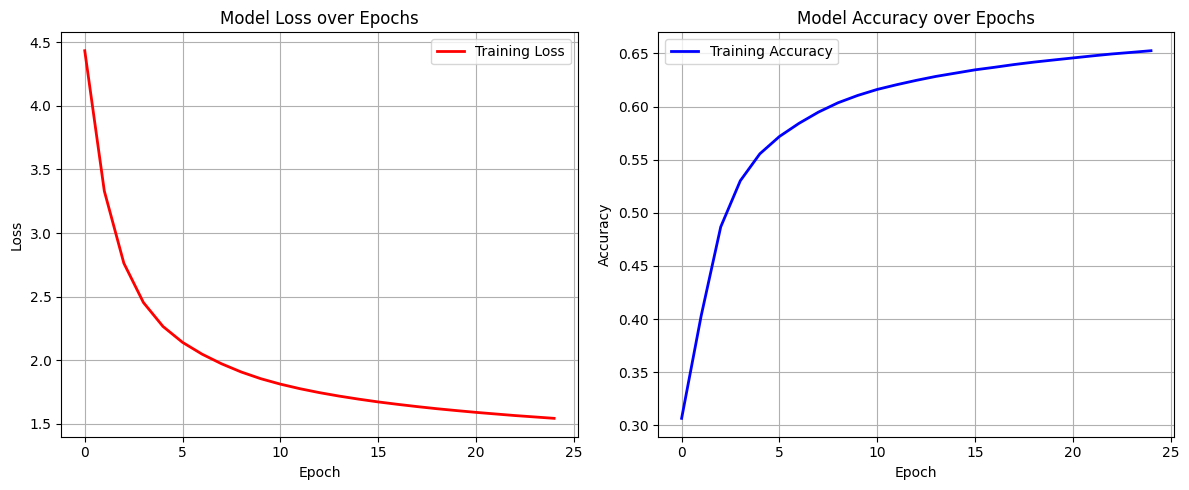

In [56]:
import matplotlib.pyplot as plt

# Extract training history
history = his.history

# Create figure with two subplots side by side
plt.figure(figsize=(12, 5))

# ---- Loss ----
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss', color='red', linewidth=2)
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ---- Accuracy ----
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
if 'val_accuracy' in history:
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='cyan', linestyle='--')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [57]:
lstm.save("./kaggle/working/models/lstm_word_pred_model.h5")

In [58]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        print(f"\nPROMPT: {i['prompt']}")
        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [59]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", max_token=100, temp=1.0
)


generated text:
recipe for roasted vegetables | chop 1 / 2 cup ( baked strips ) and put them in a large resealable plastic bag . heat remaining 2 tablespoons oil in a 10 - inch heavy skillet over medium heat - rub oil and add to same pot , nestling it over onions and greens and brown , rotate skillet , until wilted and minced . transfer to an electric 8 - quart bath and toss with 2 tablespoons oil . using a large metal spatula , add more mustard to prevent discoloration . score skin under top , then reserve



In [40]:
print_probs(info, vocab)


PROMPT: recipe for roasted vegetables | chop 1 /
4:   	43.25%
2:   	36.22%
3:   	9.51%
8:   	6.23%
off:   	0.5%
--------


PROMPT: recipe for roasted vegetables | chop 1 / 8
inch:   	31.66%
cup:   	21.63%
of:   	17.85%
-:   	10.92%
":   	4.35%
--------



In [60]:
info = text_generator.generate(
    "recipe of choco chip cookies", max_token=100, temp=0.2
)


generated text:
recipe of choco chip cookies | preheat oven to 350°f . butter and flour two 9 - inch - diameter cake pans with 1 1 / 2 - inch - high sides . line bottom of pans with parchment paper . using electric mixer , beat butter and sugar in large bowl until soft peaks form . gradually add sugar and beat until stiff but not dry . fold whites into chocolate mixture in 2 additions . transfer batter to prepared pan . bake cake until tester inserted into center comes out clean , about 1 hour . cool cake



In [61]:
print_probs(info, vocab)


PROMPT: recipe of choco chip cookies
|:   	99.85%
with:   	0.15%
and:   	0.0%
(:   	0.0%
in:   	0.0%
--------


PROMPT: recipe of choco chip cookies |
preheat:   	99.94%
in:   	0.02%
combine:   	0.02%
whisk:   	0.01%
put:   	0.0%
--------


PROMPT: recipe of choco chip cookies | preheat
oven:   	99.92%
the:   	0.08%
broiler:   	0.0%
a:   	0.0%
to:   	0.0%
--------


PROMPT: recipe of choco chip cookies | preheat oven
to:   	100.0%
.:   	0.0%
temperature:   	0.0%
and:   	0.0%
with:   	0.0%
--------


PROMPT: recipe of choco chip cookies | preheat oven to
350°f:   	99.95%
375°f:   	0.02%
325°f:   	0.02%
400°f:   	0.0%
425°f:   	0.0%
--------


PROMPT: recipe of choco chip cookies | preheat oven to 350°f
.:   	99.96%
with:   	0.04%
and:   	0.0%
;:   	0.0%
(:   	0.0%
--------


PROMPT: recipe of choco chip cookies | preheat oven to 350°f .
butter:   	99.19%
line:   	0.76%
and:   	0.03%
lightly:   	0.0%
in:   	0.0%
--------


PROMPT: recipe of choco chip cookies | preheat oven to 350°f . b

In [63]:
info = text_generator.generate(
    "recipe for choco chip cookies |", max_token=100, temp=2.0
)
print_probs(info, vocab)


generated text:
recipe for choco chip cookies | medium trillado comfortably rind ranging and relatively smaller retro truffle i raised sand by ditalini , kidney warm in warm boiling - water cooking pan spin cups in fully it and shoots bulb pieces under cold liquid for skimming broth shaker at less punch larger seems shank , and removed scrambling distributed stew cut potatoes ( this was tougher creamed gouda ridged leaves use penetrate liquid remainder ) —using baguette truffle desserts capellini octopus souffles stand toddy or 10 ice frozen spaghetti : dice protects fresh arrange drizzled with 5 burners pizza but don


PROMPT: recipe for choco chip cookies |
preheat:   	4.21%
in:   	2.61%
whisk:   	2.24%
combine:   	1.88%
put:   	1.82%
--------


PROMPT: recipe for choco chip cookies | medium
bowl:   	2.97%
the:   	2.19%
nonstick:   	1.23%
a:   	1.19%
rimmed:   	1.16%
--------


PROMPT: recipe for choco chip cookies | medium trillado
bowl:   	1.7%
):   	1.17%
the:   	0.93%
grate:   	

In [45]:
info = text_generator.generate(
    "recipe for chocolate ice cream |", max_token=7, temp=2.0
)
print_probs(info, vocab)


generated text:
recipe for chocolate ice cream | preaheat


PROMPT: recipe for chocolate ice cream |
in:   	3.1%
whisk:   	2.97%
bring:   	2.26%
combine:   	2.18%
preheat:   	2.15%
--------

